# Ejercicio 2

In [5]:
# --------- Leer el texto desde el archivo ---------
with open("Pradera\datos\informacion\Mecanica_del_juego.txt", "r", encoding="utf-8") as file:
    texto = file.read()


In [6]:
import re
# Limpieza del texto (antes de fragmentar)
def limpiar_texto(texto):
    texto = texto.strip()
    texto = re.sub(r'\s+', ' ', texto)
    return texto

texto_limpio = limpiar_texto(texto)

In [7]:
from langchain.text_splitter import CharacterTextSplitter

# Esto intenta no cortar palabras ni oraciones, buscando separadores (como "\n" o ". ") antes del límite.

# Crear el splitter
splitter = CharacterTextSplitter(
    separator="\n",            
    chunk_size=200, # Divide cada 200 caracteres
    chunk_overlap=0,           
    length_function=len
)

# Generar los fragmentos
fragmentos = splitter.split_text(texto)

# Ver cantidad de fragmentos
print(f"Total de fragmentos generados: {len(fragmentos)}")

# Ver algunos ejemplos
for i, frag in enumerate(fragmentos[:3]):
    print(f"\n--- Fragmento {i+1} ---\n{frag}")

Created a chunk of size 301, which is longer than the specified 200
Created a chunk of size 275, which is longer than the specified 200
Created a chunk of size 426, which is longer than the specified 200
Created a chunk of size 288, which is longer than the specified 200
Created a chunk of size 1086, which is longer than the specified 200
Created a chunk of size 668, which is longer than the specified 200
Created a chunk of size 466, which is longer than the specified 200
Created a chunk of size 467, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 224, which is longer than the specified 200
Created a chunk of size 254, which is longer than the specified 200
Created a chunk of size 208, which is longer than the specified 200
Created a chunk of size 425, which is longer than the specified 200
Created a chunk of size 512, which is longer than the specified 200
Created a chunk of size 500, which is longer th

Total de fragmentos generados: 49

--- Fragmento 1 ---
Conviértete en un explorador que compite con otros por ver quién es el observador de la naturaleza más hábil en un viaje para el que no se necesita más que el deseo por descubrir los misterios de la naturaleza y una mirada llena de curiosidad por cada pequeño detalle que nos encontremos en el camino.

--- Fragmento 2 ---
Así se nos presenta Pradera, diseñado por Klemens Kalicki, responsable de Dream Home. El juego fue publicado en 2021 por Rebel Studio en una versión en polaco. De las ilustraciones se encarga Karolina Kijak, siendo esta su primera incursión en el mundo de los juegos de mesa.

--- Fragmento 3 ---
Se encuentra publicado en español por Asmodee Ibérica (aunque el juego es completamente independiente del idioma). Permite partidas de 1 a 4 jugadores, con una edad mínima sugerida de 10 años y una duración aproximada de entre 60 y 90 minutos. El precio de venta al público es de 44,99€. Para esta reseña se ha utilizado una 

In [8]:
# Vectorización de los fragmentos
from sentence_transformers import SentenceTransformer
from prettytable import PrettyTable

# Cargamos el modelo preentrenado multilingüe
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Codificamos los fragmentos
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)

d:\Documentos del Administrador\Desktop\Facultad\Cuartas Materias\NLP\TP 1 Parte 2\NLP_Parte2\entorno\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from sentence_transformers import util
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
import Levenshtein as lev
import numpy as np


frases_busqueda = [
    "¿Cuáles son las reglas básicas del juego de mesa?",
    "Cómo se juega a este juego de mesa",
    "Objetivo principal del juego",
    "Tipos de cartas en el juego",
    "Estrategias ganadoras en juegos de mesa",
    "Número de jugadores recomendado para este juego",
    "¿Es este juego cooperativo o competitivo?",
    "Historia del juego de mesa",
    "¿Qué hace especial este juego?",
    "¿Cómo se distribuyen las cartas en este juego?"
]

# Codificar los fragmentos y las frases de búsqueda
embeddings = modelo.encode(fragmentos, convert_to_tensor=True)
embeddings_busqueda = modelo.encode(frases_busqueda, convert_to_tensor=True)

# Función para calcular la similitud del coseno
def similitud_coseno(embedding1, embedding2):
    return util.cos_sim(embedding1, embedding2).item()

# Función para calcular la distancia de Jaccard
def distancia_jaccard(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - intersection / union  # Jaccard devuelve la distancia, no la similitud

# Función para calcular la distancia de Levenshtein
def distancia_levenshtein(str1, str2):
    return lev.distance(str1, str2)

# Función para calcular el índice de Dice
def indice_dice(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))  # Dice devuelve la similitud

# Función para calcular la similitud de Jaro-Winkler
def similitud_jaro_winkler(str1, str2):
    return fuzz.ratio(str1, str2) / 100  # Jaro-Winkler es un porcentaje

# Crear una tabla para mostrar los resultados
tabla = PrettyTable()
tabla.field_names = ["Frase de Búsqueda", "Fragmento", "Similitud Coseno", "Distancia Jaccard", "Distancia Levenshtein", "Índice Dice", "Similitud Jaro-Winkler"]

# Comparar todas las frases de búsqueda con todos los fragmentos
for i, frase in enumerate(frases_busqueda):
    for j, fragmento in enumerate(fragmentos):
        similitud_cos = similitud_coseno(embeddings_busqueda[i], embeddings[j])
        jaccard = distancia_jaccard(frase, fragmento)
        levenshtein = distancia_levenshtein(frase, fragmento)
        dice = indice_dice(frase, fragmento)
        jaro_winkler = similitud_jaro_winkler(frase, fragmento)

        # Añadir la fila a la tabla
        tabla.add_row([frase, fragmento, f"{similitud_cos:.4f}", f"{jaccard:.4f}", f"{levenshtein:.4f}", f"{dice:.4f}", f"{jaro_winkler:.4f}"])

# Mostrar la tabla con los resultados
print(tabla)


+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

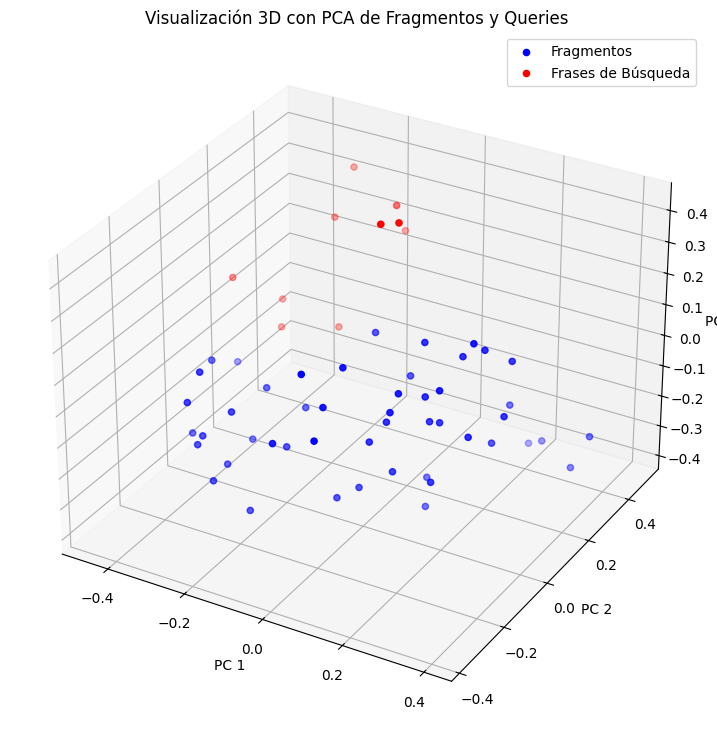

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Combina los embeddings de fragmentos y frases de búsqueda
todos_embeddings = embeddings.cpu().numpy().tolist() + embeddings_busqueda.cpu().numpy().tolist()


# Aplica PCA para reducir a 3 dimensiones
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(todos_embeddings)

# Separa fragmentos y frases de búsqueda
num_fragmentos = len(fragmentos)
emb_frag = embeddings_3d[:num_fragmentos]
emb_query = embeddings_3d[num_fragmentos:]

# Visualización 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Fragmentos en azul
ax.scatter(emb_frag[:, 0], emb_frag[:, 1], emb_frag[:, 2], c='blue', label='Fragmentos')
# Frases de búsqueda en rojo
ax.scatter(emb_query[:, 0], emb_query[:, 1], emb_query[:, 2], c='red', label='Frases de Búsqueda')



ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Visualización 3D con PCA de Fragmentos y Queries')
ax.legend()
plt.show()


# Ejercicio 3

In [11]:
import spacy

# Carga el modelo en español con soporte para POS y NER
nlp = spacy.load('es_core_news_lg')

# Creamos una lista para almacenar los sustantivos por fragmento para su posterior análisis
sustantivos_por_fragmento = []

for i, fragmento in enumerate(fragmentos):
    doc = nlp(fragmento)
    
    print(f"\n--- Fragmento {i+1} ---")
    print(f"Texto: {fragmento}\n")

    # 1. Extraer frases nominales (noun_chunks = frases con núcleo sustantivo)
    print("Frases nominales (POS):")
    for chunk in doc.noun_chunks:
        print(f" - {chunk.text}")

    # 2. Extraer entidades nombradas (NER)
    print("\nEntidades nombradas (NER):")
    for ent in doc.ents:
        print(f" - {ent.text} ({ent.label_})")

    # 3. Sustantivos (guardarlos para análisis posterior)
    sustantivos = [token.lemma_.lower() for token in doc if token.pos_ == "NOUN"]
    print("\nSustantivos extraídos (lemmatizados):")
    print(sustantivos)
    
    # Guardar en la lista principal
    sustantivos_por_fragmento.append(sustantivos)


--- Fragmento 1 ---
Texto: Conviértete en un explorador que compite con otros por ver quién es el observador de la naturaleza más hábil en un viaje para el que no se necesita más que el deseo por descubrir los misterios de la naturaleza y una mirada llena de curiosidad por cada pequeño detalle que nos encontremos en el camino.

Frases nominales (POS):
 - Conviértete
 - un explorador
 - que
 - otros
 - quién
 - la naturaleza
 - un viaje
 - el que
 - más que el deseo
 - los misterios
 - la naturaleza
 - una mirada
 - curiosidad
 - cada pequeño detalle
 - que
 - el camino

Entidades nombradas (NER):

Sustantivos extraídos (lemmatizados):
['explorador', 'observador', 'naturaleza', 'viaje', 'deseo', 'misterio', 'naturaleza', 'mirada', 'curiosidad', 'detalle', 'camino']

--- Fragmento 2 ---
Texto: Así se nos presenta Pradera, diseñado por Klemens Kalicki, responsable de Dream Home. El juego fue publicado en 2021 por Rebel Studio en una versión en polaco. De las ilustraciones se encarga Karo

In [12]:
# CODIGO PARA VISUALIZAR UN FRAGMENTO EN PARTICULAR

indice_fragmento = 2  

fragmento = fragmentos[indice_fragmento]
doc = nlp(fragmento)

print(f"\n--- Fragmento {indice_fragmento + 1} ---")
print(f"Texto: {fragmento}\n")

# 1. Frases nominales (POS)
print("Frases nominales (POS):")
for chunk in doc.noun_chunks:
    print(f" - {chunk.text}")

# 2. Entidades nombradas con explicación (NER)
print("\nEntidades nombradas (NER):")
if doc.ents:
    for ent in doc.ents:
        print(f" - Entidad: {ent.text}, Etiqueta: {ent.label_}, Explicación: {spacy.explain(ent.label_)}")
else:
    print("No se encontraron entidades nombradas en este fragmento.")


--- Fragmento 3 ---
Texto: Se encuentra publicado en español por Asmodee Ibérica (aunque el juego es completamente independiente del idioma). Permite partidas de 1 a 4 jugadores, con una edad mínima sugerida de 10 años y una duración aproximada de entre 60 y 90 minutos. El precio de venta al público es de 44,99€. Para esta reseña se ha utilizado una copia de la versión en español de Asmodee Ibérica, que la propia editorial nos ha cedido amablemente.

Frases nominales (POS):
 - español
 - Asmodee Ibérica
 - el juego
 - idioma
 - partidas
 - 4 jugadores
 - , con una edad mínima
 - 10 años
 - una duración
 - entre 60 y 90 minutos
 - El precio
 - venta
 - público
 - esta reseña
 - una copia
 - la versión
 - español
 - Asmodee Ibérica
 - la propia editorial

Entidades nombradas (NER):
 - Entidad: Asmodee Ibérica, Etiqueta: MISC, Explicación: Miscellaneous entities, e.g. events, nationalities, products or works of art
 - Entidad: El precio de venta al público, Etiqueta: MISC, Explicación: M

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# 🔹 Similitud de Jaccard
def similitud_jaccard(lista1, lista2):
    set1 = set(lista1)
    set2 = set(lista2)
    interseccion = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(interseccion) / len(union)

# 🔹 Similitud de Levenshtein
def similitud_levenshtein(lista1, lista2):
    if not lista1 or not lista2:
        return 0.0
    puntajes = []
    for palabra1 in lista1:
        mejores_similitudes = []
        for palabra2 in lista2:
            dist = distancia_levenshtein(palabra1, palabra2)
            max_len = max(len(palabra1), len(palabra2))
            if max_len == 0:
                similitud = 1.0  # ambas palabras vacías
            else:
                similitud = 1 - dist / max_len
            mejores_similitudes.append(similitud)
        puntajes.append(max(mejores_similitudes))
    return np.mean(puntajes)


# 🔹 Índice de Dice
def similitud_dice(lista1, lista2):
    set1 = set(lista1)
    set2 = set(lista2)
    interseccion = len(set1.intersection(set2))
    total = len(set1) + len(set2)
    if total == 0:
        return 0.0
    return 2 * interseccion / total

# 🔹 Similitud del Coseno (basado en bolsa de palabras)
def similitud_coseno_bow(lista1, lista2):
    documentos = [' '.join(lista1), ' '.join(lista2)]
    vectorizer = CountVectorizer().fit_transform(documentos)
    vectores = vectorizer.toarray()
    return cosine_similarity([vectores[0]], [vectores[1]])[0][0]

# 🔹 Similitud de Jaro-Winkler (promedio entre palabras)
def similitud_jaro_winkler(lista1, lista2):
    if not lista1 or not lista2:
        return 0.0
    puntajes = []
    for palabra1 in lista1:
        mejores_similitudes = [fuzz.WRatio(palabra1, palabra2) for palabra2 in lista2]
        puntajes.append(max(mejores_similitudes))
    return np.mean(puntajes) / 100  # para dejarlo en [0,1]

In [14]:
# Ejemplo: comparar fragmento 0 y 1
lista1 = sustantivos_por_fragmento[0]
lista2 = sustantivos_por_fragmento[1]

print("Similitud Jaccard:", similitud_jaccard(lista1, lista2))
print("Similitud Dice:", similitud_dice(lista1, lista2))
print("Similitud Coseno (BoW):", similitud_coseno_bow(lista1, lista2))
print("Similitud Levenshtein:", similitud_levenshtein(lista1, lista2))
print("Similitud Jaro-Winkler:", similitud_jaro_winkler(lista1, lista2))

Similitud Jaccard: 0.0
Similitud Dice: 0.0
Similitud Coseno (BoW): 0.0
Similitud Levenshtein: 0.2895316804407713
Similitud Jaro-Winkler: 0.48727272727272725


# Ejercicio 4

In [19]:
from langdetect import detect
import os
import pandas as pd

carpeta = "Pradera/datos/informacion"

# Lista para guardar los resultados
datos = []

# Recorrer todos los archivos en la carpeta
for nombre_archivo in os.listdir(carpeta):
    ruta_archivo = os.path.join(carpeta, nombre_archivo)

    # Solo procesar archivos .txt
    if nombre_archivo.endswith(".txt"):
        with open(ruta_archivo, "r", encoding="utf-8") as archivo:
            texto = archivo.read()

            # Detectar idioma
            try:
                idioma = detect(texto)
            except:
                idioma = "desconocido"

            # Guardar en la lista
            datos.append({
                "archivo": nombre_archivo,
                "idioma": idioma,
                "texto": texto
            })

# Crear el DataFrame
df_idiomas = pd.DataFrame(datos)

# Mostrar el DataFrame
df_idiomas.head()


,archivo,idioma,texto
0,comentarios.txt,es,1 Espectacular. Desde que se anunció ya me lla...
1,descripcion_general.txt,en,Meadow is an engaging set collection game with...
2,enlaces_imagenes.txt,fr,https://i0.wp.com/misutmeeple.com/wp-content/u...
3,enlaces_pagina.txt,es,#Colecciones\nhttps://misutmeeple.com/tag/cole...
4,foro_general.txt,en,Missed card packs ?: Hello everyone\n\nAfter c...


# Ejercicio 5

In [46]:
# Ruta al archivo
ruta_archivo = "Pradera/datos/informacion/comentarios.txt"

# Leer reseñas correctamente
resenias = []
reseña_actual = ""

with open(ruta_archivo, "r", encoding="utf-8") as file:
    for linea in file:
        linea = linea.strip()
        if not linea:
            continue
        # Si la línea empieza con un número y un espacio, es una nueva reseña
        if re.match(r"^\d+\s", linea):
            if reseña_actual:
                resenias.append(reseña_actual.strip())  # Guardar la anterior
            # Eliminar el número y guardar el nuevo comienzo
            reseña_actual = re.sub(r"^\d+\s+", "", linea)
        else:
            reseña_actual += " " + linea  # Continuación de la reseña actual

# Guardar la última reseña si quedó alguna
if reseña_actual:
    resenias.append(reseña_actual.strip())

# Crear DataFrame
df_resenias = pd.DataFrame(resenias, columns=["texto"])

# Verificar una reseña puntual
print(resenias[49])


Un juegazo. Y con la ultima expansión aun mas. xD


In [47]:
df_resenias.head()

,texto
0,Espectacular. Desde que se anunció ya me llamó...
1,A mi me tiene encandilado. No deja de ser un j...
2,"Gran reseña, como siempre. Está gustando mucho..."
3,A mi siempre me deja con ganas de seguir jugan...
4,"Hola Iván, la verdad es que me has sorprendido..."
